In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from params import *

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

env = gym.make(envs[env_to_use]).unwrapped
if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale,lr):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    p_exp = population_exponent
    if population_exponent <= 0:
        p_exp = fitness
        
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/p_exp#population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,lr[p],device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    a_gen_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r,_ = dis(real_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (torch.pow((dis_out_r[...,0]-rank),2))
            
            dis_error_real_mean = torch.mean(dis_error_real)
            dis_error_real_mean.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.pow(dis_out_r[...,1]-dis_error_real.detach(),2))
            dis_confidence.backward()
            
            dis_optimizer.step() 
            
            

        #for i in range(len(population)//batch_size):
            #generate children from population
            mutation = torch.from_numpy(np.random.uniform(all_a,all_a,batch_size)).type('torch.FloatTensor').to(device)
            
            child,a_gen = gen_children(population,device,gen,batch_size,a = mutation)
            a_gen = torch.mean(torch.abs(a_gen))
            #train discriminator
            dis_out_f,dis_out_last = dis(child)
            dis_out_f = dis_out_f.squeeze(-1)
            
            gen_optimizer.zero_grad()
            
            #define generator loss
            variety = -torch.std(dis_out_f[...,0])#-torch.mean(torch.std(dis_out_last,-1))
            
            gen_error_exploration =  (variety)-torch.mean(dis_out_f[...,1])
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) 
            gen_error =  gen_error_exploitation + (gen_error_exploration)
            
            gen_error.backward()
            gen_optimizer.step() 
            gen.hidden = None
            #keep losses to draw graph 
            a_gen_all.append(a_gen)
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            dis_loss_all.append(dis_error_real_mean)  
            dis_confidence_all.append(dis_confidence)
            
    print(rank)
    print(dis_out_r[...,0])
    #print(get_params(population[0]))
    #print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all,a_gen_all,dis_confidence_all


starting training
740
Measured population fitness : 4s
population fitness : [-111.64411882  -58.13223419 -110.62280579 -119.30666746  -92.72024147
 -111.2458177   -38.45974089 -108.71979739  -22.13244299  -29.69485866]
mean fit : -80.26787253367556
tensor([ 1.5805, -0.8530, -0.7735,  1.3749,  1.1366, -0.3385, -0.8422, -0.8253,
         0.6018, -1.0613], device='cuda:0')
tensor([ 1.4995, -0.9019, -0.7991,  1.2849,  1.0473, -0.3663, -0.8471, -0.8538,
         0.5550, -1.1202], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


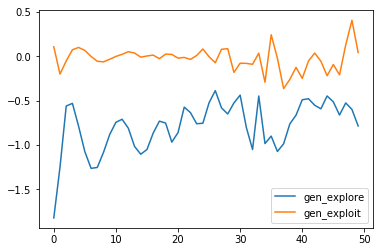

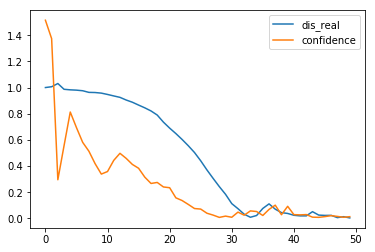

Generation 1  fitness : -22.132442988914526
#################################
Measured population fitness : 6s
population fitness : [ -21.82720752 -110.58670693  -19.05762352  -57.57743221  -96.68416904
  -40.93608477  -93.26698598 -112.08533216   -8.32740799  -69.31576336]
mean fit : -62.9664713483355
tensor([ 0.3692, -0.6592,  1.3821,  0.8719, -1.2541,  1.6643,  1.3093,  0.0605,
        -1.0257,  1.1024, -1.0421, -0.5549, -0.5693,  1.3013,  0.3546, -1.0642,
        -1.0526,  0.8068, -1.0248, -0.9757], device='cuda:0')
tensor([ 0.4242, -0.7166,  1.1193,  0.7325, -1.3169,  0.6441,  1.1249,  0.0349,
        -1.1668,  1.1302, -1.1613,  0.2832, -0.4408,  1.1249,  0.2093, -1.0325,
        -1.1319,  0.7325, -1.1025, -1.0934],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


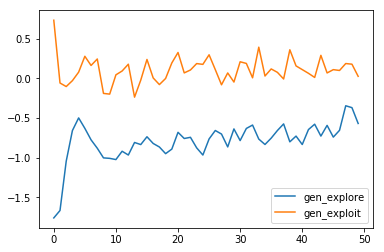

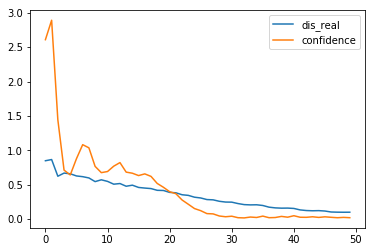

Generation 2  fitness : -8.327407988783058
#################################
Measured population fitness : 3s
population fitness : [ -92.75992346  -93.64923551  -32.8627275   -37.43638386 -113.34086815
 -102.25634432 -102.25881291  -95.28342754  -95.19078329  -44.49187743]
mean fit : -80.95303839698056
tensor([ 0.9532,  1.5704, -1.0537,  0.1527, -0.6193, -0.5086,  0.8529, -0.7765,
         1.4922, -0.5337,  1.1809, -0.5229,  1.8730, -0.7765,  1.0519, -0.5798,
        -1.0115,  0.4838, -1.0891, -0.5772], device='cuda:0')
tensor([ 0.5599,  1.3327, -0.3637,  0.0753, -0.6971, -0.4563,  0.6486, -0.1370,
         1.4593, -0.3881,  0.9735, -0.4746,  0.8783,  0.0328,  0.2077,  0.0032,
        -0.8543,  0.5725, -0.4385, -0.4697],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


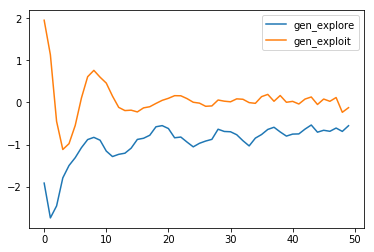

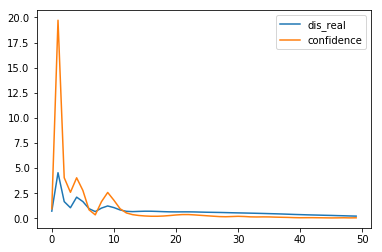

Generation 3  fitness : -32.8627275021084
#################################
Measured population fitness : 8s
population fitness : [ -35.57567863  -36.64433914  -98.24910284  -68.61250919  -17.69456562
  -28.77145605 -112.47212064  -23.94926307  -94.66336361  -42.11479718]
mean fit : -55.874719597872755
tensor([-0.6888,  1.2874, -0.9010,  0.9326, -0.7061,  1.1526, -1.2108, -0.6356,
        -0.9011,  0.7133,  0.9104, -0.6605,  1.0383,  1.4621, -0.7035,  0.7797,
        -0.7890,  0.0392, -1.1865,  0.9624], device='cuda:0')
tensor([-0.5134,  1.2109, -0.9861,  0.7352, -0.6096,  1.1974, -1.3008, -0.1763,
        -0.9999,  0.8822,  1.0281, -0.4823,  0.7004,  1.3740, -0.6365,  0.6956,
        -0.9236,  0.0606, -0.9608,  0.9521],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


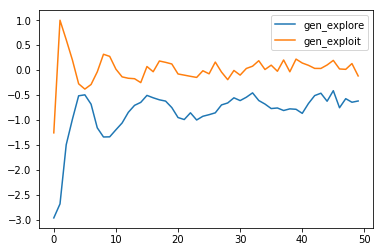

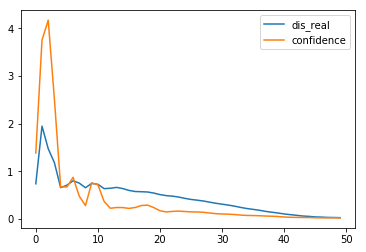

Generation 4  fitness : -17.694565617540967
#################################
Measured population fitness : 3s
population fitness : [-111.27304486  -95.19917067  -18.49663323 -111.75385946 -111.78491785
 -105.44105521  -93.61787822  -12.48843114  -95.47705464  -54.95010859]
mean fit : -81.04821538699903
tensor([ 1.4850,  1.2010, -1.0794,  1.6510, -0.6351,  0.8322,  0.9834,  1.0129,
         1.3342, -1.1125,  0.0998, -0.9182, -0.6428, -0.6203, -1.0935, -0.5914,
         0.4774, -1.0926, -0.7194,  1.5071], device='cuda:0')
tensor([ 1.5179,  0.4970, -0.6794,  1.7262, -0.3396,  0.9543,  1.0011,  0.4992,
         1.2244, -1.1432,  0.1096, -1.0327,  0.0848, -0.4865, -0.8705,  0.0279,
         0.7361, -1.0493, -0.7295,  1.2499],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


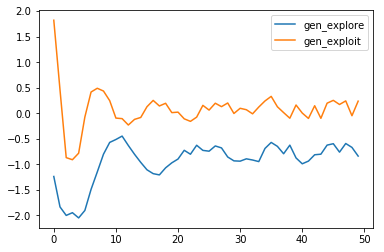

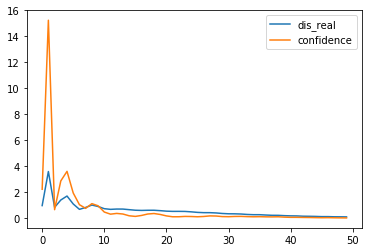

Generation 5  fitness : -12.488431142368668
#################################
Measured population fitness : 6s
population fitness : [ -92.49605909  -11.26923457 -100.24572763  -93.70009671  -41.19243921
  -36.82508562  -98.54194953  -29.24981277  -42.673005    -21.70506034]
mean fit : -56.7898470469439
tensor([ 1.1162, -0.6622,  0.9069, -1.1500, -0.7059,  0.7453, -0.7982,  1.6129,
        -1.1632,  0.4061, -0.7135, -0.9888,  1.5793, -0.6312, -1.1641,  1.4133,
        -0.8453, -0.6645,  1.3246,  0.7862], device='cuda:0')
tensor([ 1.1571, -0.7478,  0.8863, -1.0424, -0.5995,  0.4337, -0.6876,  1.5189,
        -1.2517,  0.5810, -0.6470, -1.1855,  1.5189,  0.1951, -1.1732,  1.4607,
        -0.4238, -0.7364,  0.4678,  0.8368],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


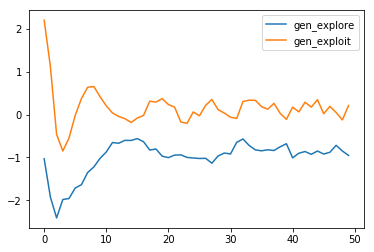

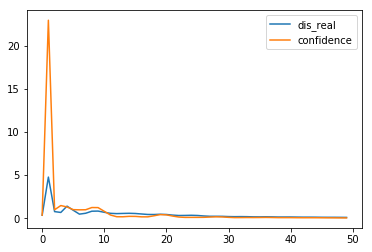

Generation 6  fitness : -11.269234568246452
#################################
Measured population fitness : 3s
population fitness : [ -32.13234246  -94.16287494 -129.77421037  -93.93819228  -92.84041433
 -110.82425889  -93.19626941  -10.44115172  -92.73948108  -32.35401902]
mean fit : -78.24032144788953
tensor([ 1.6360, -0.7593,  0.7741, -0.8060, -0.6264,  0.8147, -1.6164, -0.6391,
         1.3495,  1.0634, -1.0964,  1.0573, -0.6028,  1.1425,  0.9346, -0.6000,
        -0.6126, -0.6329, -0.5933,  1.6587], device='cuda:0')
tensor([ 1.4941, -0.8223,  0.6945, -0.7401, -0.7377,  0.8415, -1.7728, -0.6530,
         0.6619,  1.0409, -1.1374,  0.9318, -0.5611,  1.1078,  0.9318, -0.6132,
        -0.4759, -0.6662, -0.0829,  1.6910],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


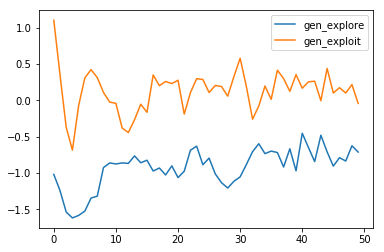

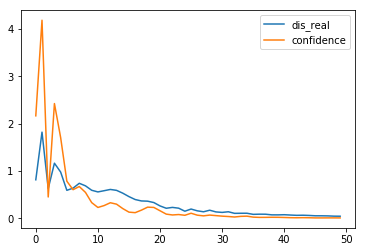

Generation 7  fitness : -10.441151716101148
#################################
Measured population fitness : 3s
population fitness : [ -42.1031406   -93.35457084  -49.26485358 -119.03806591  -93.68438336
  -93.71128471   -7.70846315  -95.18011014  -95.05208199 -113.50399288]
mean fit : -80.26009471665725
tensor([ 1.7763,  0.8268, -0.6043, -0.5740, -1.2972, -1.0705, -1.1444, -1.5936,
         1.1020, -0.6386, -0.5980,  0.6290, -0.5712, -0.5973, -0.5882, -0.6105,
         1.7009, -0.6350,  1.0959, -0.5838], device='cuda:0')
tensor([ 1.8468,  0.8760, -0.5283, -0.6242, -1.3259, -1.0799, -1.1503, -1.6130,
         1.0313, -0.6478, -0.6848,  0.6480, -0.6641, -0.7208, -0.6846, -0.6555,
         1.5451, -0.6145,  1.0232, -0.5692],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


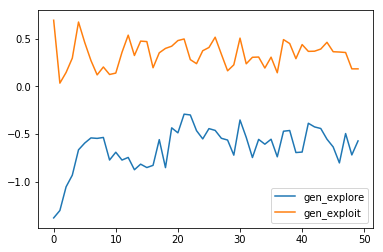

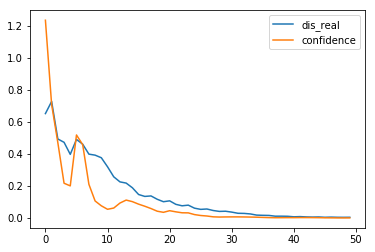

Generation 8  fitness : -7.70846314793398
#################################
Measured population fitness : 6s
population fitness : [-93.73487485 -21.15857857 -98.26064527 -95.03390428 -58.83813098
 -41.58384994 -27.05090028 -92.44487205 -92.40332246 -51.00866676]
mean fit : -67.15177454511802
tensor([-1.3378, -0.6250, -1.1821, -0.6622, -0.6242, -0.5893,  0.3565,  1.2512,
         1.4170,  0.8275, -0.6256,  0.8422, -0.6627, -0.6663,  0.6260,  0.5769,
        -0.6149, -0.5882,  1.7956, -0.7530], device='cuda:0')
tensor([-1.3172, -0.6192, -1.1361, -0.5868, -0.6232, -0.5617,  0.4015,  1.2473,
         1.4780,  0.8638, -0.6410,  0.8638, -0.6500, -0.6474,  0.6681,  0.6345,
        -0.5410, -0.5646,  1.8036, -0.7061],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


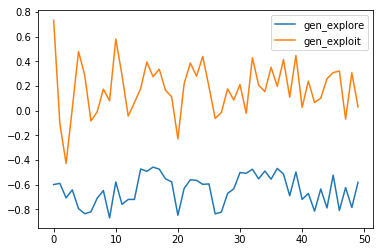

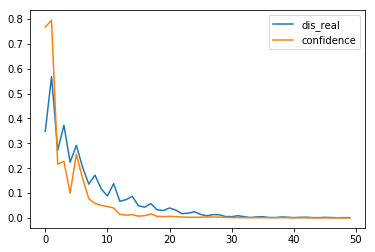

Generation 9  fitness : -21.15857857479405
#################################
Measured population fitness : 9s
population fitness : [-98.02781642 -50.52237136 -64.90442338 -96.03877024 -53.73891056
 -63.38169103 -49.12375462 -48.42055559 -34.2385867  -36.50044495]
mean fit : -59.48973248439356
tensor([ 0.9787, -0.7451,  0.6132, -0.8094,  0.8316,  0.4796,  1.0442, -0.6398,
         0.1563,  0.6336,  1.4229, -0.7160,  0.5728,  0.3320, -0.6410, -0.6784,
         1.2523,  0.2004, -0.8027,  0.5587], device='cuda:0')
tensor([ 0.9954, -0.7129,  0.6355, -0.7899,  0.5690,  0.4697,  1.0645, -0.6285,
         0.1298,  0.5963,  1.4431, -0.7141,  0.6032,  0.3664, -0.6176, -0.7120,
         1.3199,  0.2224, -0.6076,  0.5599],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


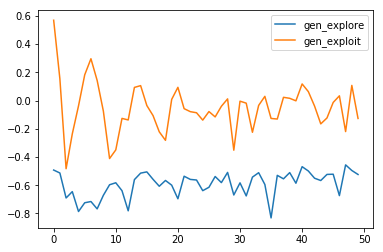

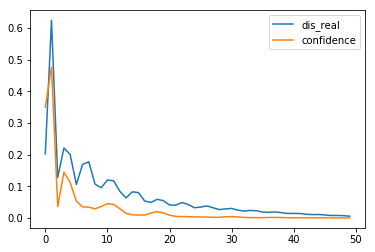

Generation 10  fitness : -34.23858670352939
#################################
Measured population fitness : 5s
population fitness : [ -39.89593587  -95.1258375  -115.74280846 -121.61270783  -93.82892696
  -58.94306999 -120.34075815  -47.30962454  -38.51741689 -118.58398365]
mean fit : -84.99010698197678
tensor([ 0.6087,  0.6693, -1.2713,  1.0781,  0.9150, -1.4038, -0.7033,  0.3660,
        -0.7607,  1.0129,  0.9547,  0.1941, -0.6770,  0.2380, -1.4405,  0.7013,
        -0.6396, -1.3532,  0.6490,  0.5160], device='cuda:0')
tensor([ 0.6308,  0.6393, -1.3191,  1.0131,  0.6618, -1.0553, -0.7174,  0.3489,
        -0.7778,  1.0772,  0.9892,  0.2516, -0.6309,  0.2925, -1.4136,  0.7528,
        -0.6947, -1.4176,  0.6726,  0.4461],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s
Evolved : 0s


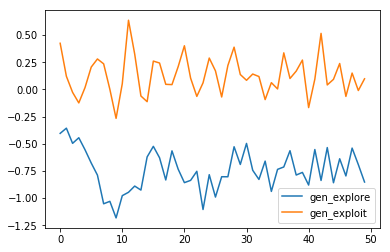

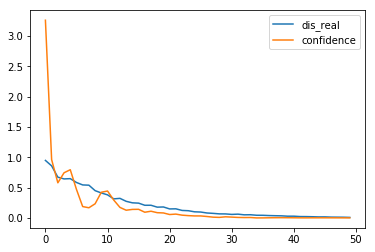

Generation 11  fitness : -38.51741688706816
#################################


In [ ]:
#population_size = 10
#max_population = population_size
#max_population_batch = 2
#out_size = population_size
#n_generations = 300

#randomly inititialise starting population
population = []

for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
all_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.9,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    #if len(all_fitnesses) > 5:
    #    all_fitnesses.pop(0)
        
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch_normed = ((fitness_batch - np.mean(all_fitnesses))/np.std(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.mean(all_fitnesses))/(np.max(all_fitnesses)-np.min(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.min(all_fitnesses))/np.sum(all_fitnesses)
    #Train GAN
    start_time = time.time()
    gen_explore_all,gen_exploit_all, dis_loss ,a_gen_all,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              batch_size =fitness_batch.size,n_epochs = 50)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    
    mr = np.random.choice([mutation_rate, 0], fitness_batch.shape,p=[creature_mutation_rate,1-creature_mutation_rate])
    
    all_r = 1
    all_r = np.random.choice([1, 0], p_fitness_.shape,p=[all_r,1-all_r])
    al_lr = all_r * all_a#* np.abs(np.random.normal(scale = 1,size = p_fitness_.shape))*all_a
   # al_lr = np.array([0]*p_fitness_.size)
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mr,mutation_scale,al_lr)
    gen.hidden = None
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
env = gym.make(envs[-2]).unwrapped
fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 2000)
print(fitness)

In [ ]:
print(fitness)